## ch07. 앙상블 학습과 랜덤포레스트

앙상블 학습은 여러개의 분류기를 생성하여 그 예측을 결합함으로써 정확한 최종 예측을 도출하는 기법을 말한다.<br>
ex) 랜덤포레스트, 그래디언트 부스팅

<앙상블 학습의 유형>

1. 보팅(Voting) : 여러개의 다른 알고리즘을 동일한 데이터에 적용하여 최종예측
2. Bagging : Bootstrap Aggregation을 의미. 단일알고리즘을 여러개로 샘플링된 데이터에 적용하여 최종예측
3. Boosting : 가중치를 사용하여 약분류기를 강분류기로 만드는 과정을 의미한다. 분류기가 순차적으로 학습을 수행하며 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에서는 가중치를 부여한다.
4. Stacking : 개별모델이 예측한 데이터를 다시 trainset이용, 새로운 메타모델에 적용한다

<br>
부스팅은 배깅보다 오류가 적지만 느리고, 오버피팅될 가능성이 높다. 무엇을 선택할 지는 상황에 따라 달라진다. 개별 결정 트리의 낮은 성능이 문제라면 부스팅이 적합하고, 오버 피팅이 문제라면 배깅이 적합하다.

### 7.1. 투표기반 분류기

**voting의 유형 - hardvoting과 softvoting** <br>
1. hardvoting : 예측한 결괏값들 중 다수의 분류기가 결정한 예측값을 최종 보팅의 결괏값으로 선정하는 것
2. softvoting : 분류기들의 레이블 값 결정확률을 모두 더하고 이를 평균하여 확률이 가장 높은 레이블 값을 최종 보팅 결괏값 채택
하드보팅보다는 소프트보팅의 예측성능이 좋아 더 많이 사용된다.

hard voting

In [1]:
#데이터 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y=make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42)

In [2]:
#여러개의 분류기를 조합하여, voting분류기 만드는 경우
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf=LogisticRegression(solver='liblinear', random_state=42)
rnd_clf=RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf=SVC(gamma="auto", random_state=42)

#보팅 기반으로 여러개의 알고리즘 조합을 적용하는 경우
voting_clf=VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [3]:
#학습
voting_clf.fit(X,y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [4]:
#정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


soft voting

In [5]:
#다른 데이터셋으로 소프트 보팅 적용하는 경우 
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
cancer=load_breast_cancer() #데이터셋 로드
data_df=pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


로지스틱 회귀와 knn을 기반으로 하여 소프트보팅 방식으로 새롭게 보팅분류기를 만들어본다 앙상블방법을 사용하여 분류하는데 사용되는 모델은 다양할 수 있다. 이에 대해 앙상블을 사용하되, 최종결정을 어떻게 내리느냐에 따라 나눠진다.  

In [9]:
import warnings
warnings.filterwarnings('ignore')
#로지스틱회귀와 KNN을 기반으로 하여 소프트 보팅방식으로 새롭게 보팅 분류기를 만들어 본다. 
#개별 모델은 KNN과 로지스틱이다.
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred))) #소프트부팅의 결과

Voting 분류기 정확도: 0.9474


In [10]:
#개별모델의 학습/예측/평가
classifiers=[lr_clf, knn_clf] #개별모델의 이름 저장 리스트

for classifier in classifiers : 
    classifier.fit(X_train, y_train)
    pred=classifier.predict(X_test)
    class_name=classifier.__class__.__name__
    print('{0} 정확도: {1: .4f}'.format(class_name, accuracy_score(y_test,pred))) #개별 결과

LogisticRegression 정확도:  0.9386
KNeighborsClassifier 정확도:  0.9386


### 7.2.배깅과 페이스팅
- **배깅**:훈련셋의 서브셋을 무작위로 구성하여 각기 다르게 분류기를 학습시키는 경우. 훈련셋에서 중복을 허용하여 샘플링하는 방식
- **같은 알고리즘으로 여러개의 분류기를 만들어 voting으로 최종 결정하는 알고리즘**
- **페이스팅**: 중복을 허용하지 않고 샘플링하여 모델을 적용하는 경우 <br>
- 예측모델을 돌린후에는 수집함수는 전형적으로 **분류**일 때, **통계적최빈값**을 따지며, **회귀**일때는 평균을 계산한다.<br>
- 또 앙상블의 결과, 편향과 분산이 모두 줄어든다. 

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9473684210526315


### 7.2.2. oob평가
배깅을 사용하면 어떤 샘플은 여러번 샘플링 되고, 어떤 것은 전혀 선택되지 않는다. 즉 선택되지 않은 샘플을 out of bag 샘플이라고 하는데 이를 사용하여 검증 셋이나 교차검증을 한다. 

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9582417582417583

In [14]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.956140350877193

### 7.3. 랜덤패치와 랜텀 서브스패이스
- BaggingClassifier는 특성샘플링의 지원.
- max_samples, bootstrap_features로 조절한다. 
- **랜덤패치방식**: 훈련데이터, 특성을 모두 샘플링
- **랜덤서브스패이스**: 훈련샘플을 모두 사용하고 특성은 샘플링하는 방식
- 더 다양한 예측기를 만들고 편향을 늘리는 대신 분산을 낮춘다. 

### 7.4. 랜덤 포레스트
- 결정트리를 배깅방법으로 만든 앙상블
- BaggingClassifier 대신 RandomForestClassifier을 사용하여 결정트리에 최적화된 모델의 사용이 가능


In [17]:
#bagging방식으로 사용하는 경우
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [20]:
#정확도(pred=real값인 경우의 확률)
import numpy as np
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.9912280701754386

### 7.4.1. 엑스트라 트리
- 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다
- 트리를 더욱 무작위로 만들기 위해 특성의 서브셋을 만들어 분할에 사용한다. 
- 최적의 임곗값의 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다. 
- 하지만 RandomForestClassifier보다 성능이 좋다고 할 수는 없다. gridSearch를 사용하여 하이퍼파라미터 튜닝을 해야 한다.

### 7.4.2. 특성중요도
- 랜덤포레스트의 또다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다. 

In [21]:
#특성중요도 확인
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [25]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [26]:
#mnist 에서 픽셀의 중요도도 뽑아낼 수가 있다. 
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

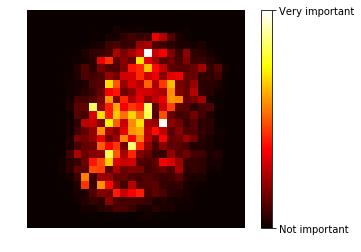

In [32]:
import matplotlib.pyplot as plt
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

### 7.5.부스팅
부스팅은 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 방법입니다. 
- AdaBoosting
- GradientBoosting

#### 7.5.1.AdaBoosting
이전모델에서 과소적합되었던 훈련샘플의 가중치를 더 높이는 것이다. **새로운 예측기는 학습하기 어려운 샘플에 더 맞춰지게 된다. (강분류기로 만드는 과정)** 두번째 분류기는 업데이트된 가중치를 사용하여 훈련셋에서 훈련하고 다시 예측한다. 가중치를 업데이트하되, 잘못분류된 경우는 작은 가중치를 두고, 잘 분류된 경우는 가중치를 많이 두어 올바른 분류가 되도록 가중치를 조절하면서 출력하는 방식이다.<br>


In [44]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, #얕은 200개의 결정트리를 앙상블로 학습시키는 경우
    algorithm="SAMME.R", learning_rate=0.5, random_state=42) #결정트리를 기반으로 하는 adaboosting
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

### 7.5.2.그래디언트 부스팅
- 마찬가지로 약분류기를 학습시켜 강분류기로 만드는과정이고 순차적인 학습방법을 사용하는 경우이다. 
- adaboot의 경우는 샘플의 가중치를 수정하여 반복하는 경우라면 그래디언트부스팅은 **잔여오차**에 새로운 학습기를 학습시키는 과정이다.
- 그래디언트 트리부스팅, 그래디언트 부스티드 회귀 트리(GBRT)

In [48]:
#랜덤값으로 X,y값을 생성함
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [49]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1=DecisionTreeRegressor(max_depth=2)  #학습시킬 첫번째 모델
tree_reg1.fit(X,y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2) #학습시킬 두번째 모델


y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3) #학습시킬 세번째 모델

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

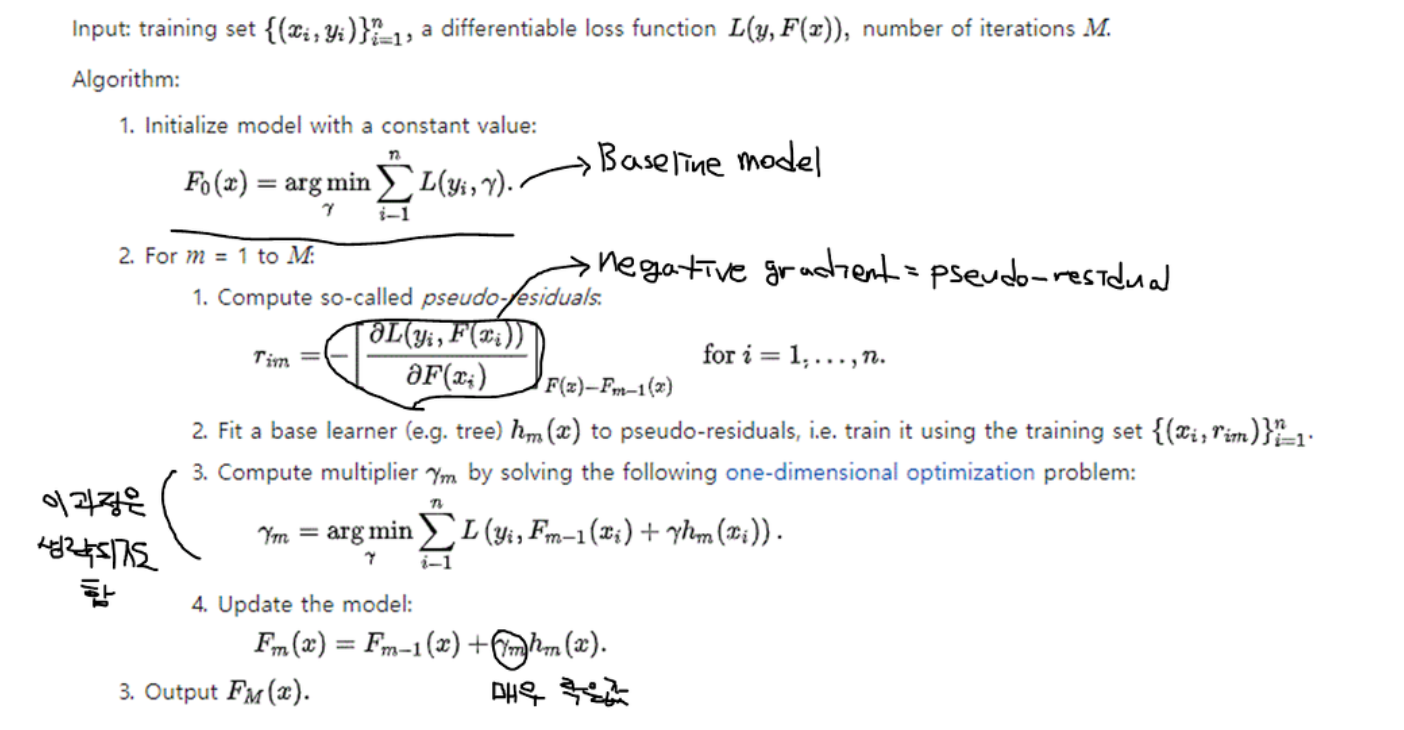

"잔여오차"를 하나의 함수로 만든다는 의미이다. 즉 이 함수를 계속 학습시키면서 작아지도록 하는 계수를 도출하는 것이 목적이다. 

In [59]:
#GRBT모델의 학습
from sklearn.ensemble import GradientBoostingRegressor

gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y) #학습

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

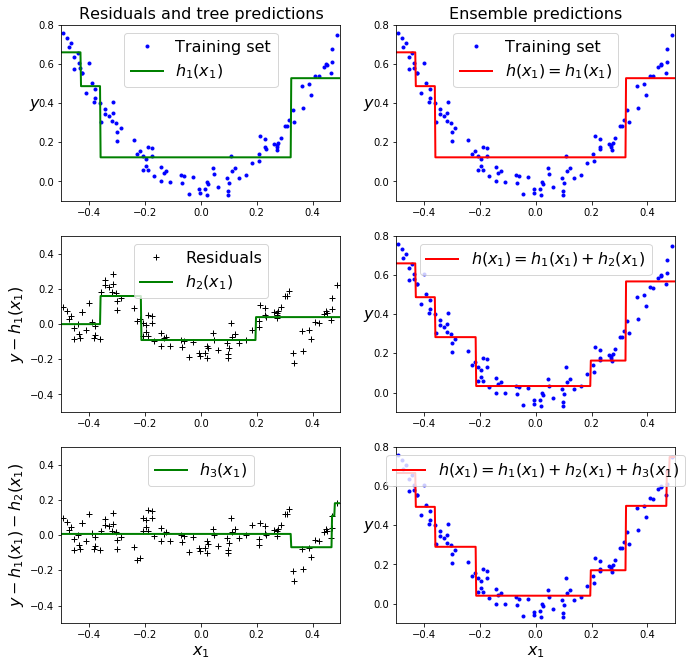

In [61]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

왼쪽의 그래프는 결국 **오차**에 대한 그래프이다. 즉 이 오차에 대한 그래프를 계속 학습시키면서(update)하면서 줄어들도록 하는 parameter값을 찾는 것이 목표이다. 그러니 오른쪽은 **fitting**된 그 그래프 자체를 의미하는데, 이 그래프가 점점 data에 잘 fit되는 것을 볼 수가 있다.(오차가 줄어듦으로)

또 마찬가지로 update를 진행하면서 학습을 하므로, learning rate를 지정할 수가 있다. learning_rate 매개변수가 각 트리의 기여정도를 조절한다. (여러개의 트리를 학습시키는 경우이므로, 각 트리의 기여도를 조절하는 것이 가능하다) <br>
일반적으로 learning_rate를 낮게 설정하면 성능이 좋아지고 이를 '축소' 규제방법이라고 한다. 

### Gradient Boosting with 조기종료(최적의 트리수)

최적의 트리수를 찾는 방법을 **조기종료방법**이라고 한다. <br>
아래의 코드에서는 120개의 트리로 GBRT앙상블을 훈련하고, 최적의 트리수를 찾기 위해 각 훈련단계에서 검증오차를 측정한다. 

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train,X_val, y_train, y_val=train_test_split(X,y, random_state=49)

#gbrt학습
gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

#오차
errors=[mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators=np.argmin(errors)+1 #오차를 최소화 하는 트리값

gbrt_best=GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
min_error=np.min(errors) #오차의 최소화

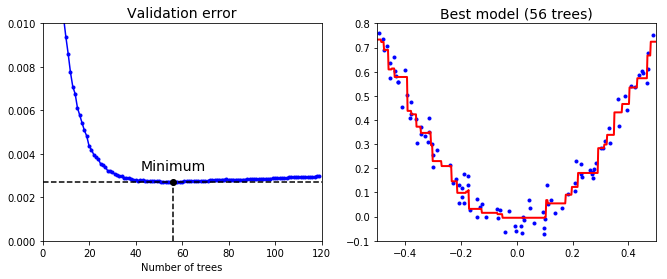

In [66]:
#오차를 최소화하는 최적의 estimator(트리의 수) 확인
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

앞에 코드에서는 우선 gbrt를 먼저 학습시킨 후에 오차를 최소화할 수 있는 방법으로 best estimator을 찾은 다음, 그 best parameter값을 대입하여, best_gbrt를 다시 학습하고, 그 결과를 나타내는 과정으로 보여줬음. <br>
하지만 굳이 학습시키고, 다시 best값을 구할 필요가 없이 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수가 있다. 아래의 코드는 다섯번의 반복동안 검증오차가 향상되지 않으면 훈련을 멈추게 하는 코드이다. 

In [67]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

### 7.6. 스태킹
- 각각의 개별 예측기에 대한 예측값으로 새로운 메타모델(=블랜더)을 활용하여 최종예측값을 만드는 방법을 스태킹이라고 한다. 
- 블랜더를 학습시키는 일반적인 방법은 홀드아웃세트를 사용하는 것입니다. (아래 그림을 참고-새로운 서브셋을 생성하여, 예측에 활용하는 것을 의미한다)
- 

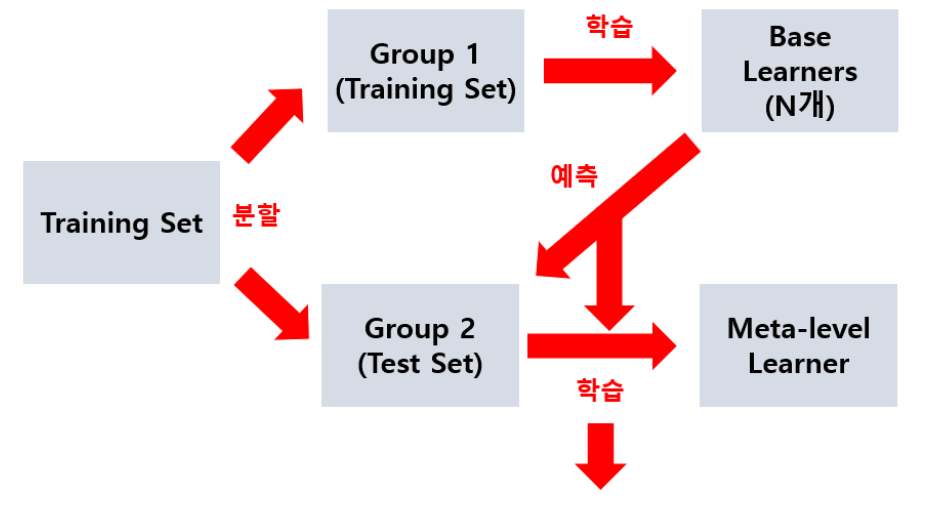